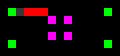

0 0 4 0
test1: None 24


In [1]:
from PIL import Image
from IPython import display
import numpy as np
import cv2
import random
import copy
import math
import time

import sys

sys.setrecursionlimit(5000)

#print image
def pretty(M,L,p,i,w,h):
    m=np.zeros([h,w,3]).astype(np.uint8)
    for x,y in M.keys() :
        m[y,x,:]=[55,55,55]
    for x,y in p:
        m[y,x,:]=[255,0,255]
    for v in L.keys():
        x,y=L[v]
        if v.isupper():
            if not v.lower() in i:
                m[y,x,:]=[255,0,0]
        else:
            if not v in i:
                m[y,x,:]=[0,255,0]
    F=8
    m = cv2.resize(m, fx=F, fy=F, dsize=(0, 0), interpolation=cv2.INTER_NEAREST)
    display.clear_output(wait=True)
    display.display(Image.fromarray(m))

#load data
def ld(d):
    #d=open("18.txt").read()
    d=d.split('\n')
    M={}
    L={}
    p=None
    i=[]
    for y,l in enumerate(d):
        for x,v in enumerate(l):
            
            #M[p]='.'
            if v=='@':
                M[(x,y)]='.'
                p=(x,y)
            elif v.isalpha():
                L[v]=(x,y)
                M[(x,y)]='.'
            elif v=='.':
                M[(x,y)]='.'
    
    #split into 4 compartments
    x,y=p
    for ii in range(-1,2):
        
        if (x+ii,y) in M:
            del M[(x+ii,y)]
        if (x,y+ii) in M:
            del M[(x,y+ii)]
    p=[(x-1,y-1),(x+1,y-1),(x+1,y+1),(x-1,y+1)]    
    
    #remove dead ends
    while 1:
        done=1
        for x,y in M.keys():
            if not (x,y) in L.values() and not (x,y) in p:
                c=0
            
                for dx,dy in [(1,0),(-1,0),(0,1),(0,-1)]:
                    tt=(x+dx,y+dy)
                    if tt in M:
                        c+=1
                    
                if c==1:
                    del M[(x,y)]
                    done=0
                    break
        #pretty(M,L,p,i,len(d[0]),len(d))
        #print(len(M.keys()))    
                
        
        if done:
            break
    
    
    return M,L,p,i,len(d[0]),len(d)
                
   
    
""" 
#distance
def dist(a,b):
    x0,y0=a
    x1,y1=b
    dx=int(abs(x1-x0))
    dy=int(abs(y1-y0))
    #return math.sqrt(dx*dx+dy*dy)
    return dx+dy
"""
FM={}
def find(M,x0,y0,x1,y1,cost=0,past=[]):
    desc=(x0,y0,x1,y1)
    if desc in FM:
        return FM[desc]
    
    if x0==x1 and y0==y1:
        return cost
    
    for dx,dy in [(1,0),(-1,0),(0,1),(0,-1)]:
        xx=x0+dx
        yy=y0+dy
        if (xx,yy) in M:
            if not (xx,yy) in past:
            
                r=find(M,xx,yy,x1,y1,cost+1,past+[(x0,y0)])
                if r:
                    FM[desc]=r
                    return r
    FM[desc]=None
    return None

def H(M,p,i,L,w,h):
    r=0
    for px,py in p:
        for k in L.keys():
            if k.islower() and not k in i:
                tx,ty=L[k]
                rr=find(M,px,py,tx,ty)
                if rr and r>rr:
                    r=rr
    return r
            
    


#recursive steps to speed up search
def _walk(M,L,Linv,x,y,lx,ly,i,cost=1):
    if (x,y) in L.values() and not Linv[(x,y)] in i:
        return (x,y),cost
    if (x,y) in M:
        nxt=[]
        for dx,dy in [(1,0),(-1,0),(0,1),(0,-1)]:
            p2=(x+dx,y+dy)
            if p2 in M and p2!=(lx,ly):
                nxt.append(p2)
        if len(nxt)==1:
            return _walk(M,L,Linv,nxt[0][0],nxt[0][1],x,y,i,cost+1)
        else:
            return (x,y),cost
    return None,0

#cached search 
walkmem={}
def walk(M,L,Linv,x,y,lx,ly,i):
    desc=(x,y,lx,ly,tuple(set(i)))
    if desc in walkmem:
        #print("mem")
        return walkmem[desc]
    r=_walk(M,L,Linv,x,y,lx,ly,i)
    walkmem[desc]=r
    return r


tstd="""###############
#d.ABC.#.....a#
######   ######
###### @ ######
######   ######
#b.....#.....c#
###############"""





def p1(d): 
    steps=0
    M,L,p,i,w,h=ld(d)
    Linv={}
    for k in L.keys():
        Linv[L[k]]=k
    allkeys=sum([1 if v.islower() else 0 for v in L.keys()])
    past={}
    e=[(p,i,0,H(M,p,i,L,w,h))]
    lasttime = time.time() 
    pretty(M,L,p,i,w,h)
    #print(L,p)
    #time.sleep(10)
    while len(e):
        p,i,c,_=e[0]
        e=e[1:]
        
        t = time.time()
        if t > lasttime:
            lasttime = t + 3
            pretty(M,L,p,i,w,h)
            print(steps,len(i),allkeys,c)
        
        if len(i)==allkeys:
            print("goal")
            return c
        
        for pix in range(len(p)):
            for dx,dy in [(1,0),(-1,0),(0,1),(0,-1)]:
                p2=copy.copy(p)
                x,y=p2[pix]
                cost=0
                if 0:
                    p2[pix]=(x+dx,y+dy)
                    cost=1
                else:
                    p2[pix],cost=walk(M,L,Linv,p2[pix][0]+dx,p2[pix][1]+dy,p2[pix][0],p2[pix][1],i)
                if p2[pix] in M:
                    i2=copy.copy(i)
                    if p2[pix] in Linv:
                    
                        v=Linv[p2[pix]]
                        #print(v)
                        #return
                        if v.isupper():
                            if not v.lower() in i2:
                                #no key no walk
                                break
                        else:
                            if not v in i2:
                                #pickup key
                                i2.append(v)
                    dsc=(tuple(set(p2)),tuple(set(i2)))
                    if not dsc in past:
                        e.append((p2,i2,c+cost,H(M,p2,i2,L,w,h)))
                        past[dsc]=1
        e=sorted(e,key=lambda x: sum(x[2:]),)
        steps+=1
        
    
print("test1:",p1(tstd),24)





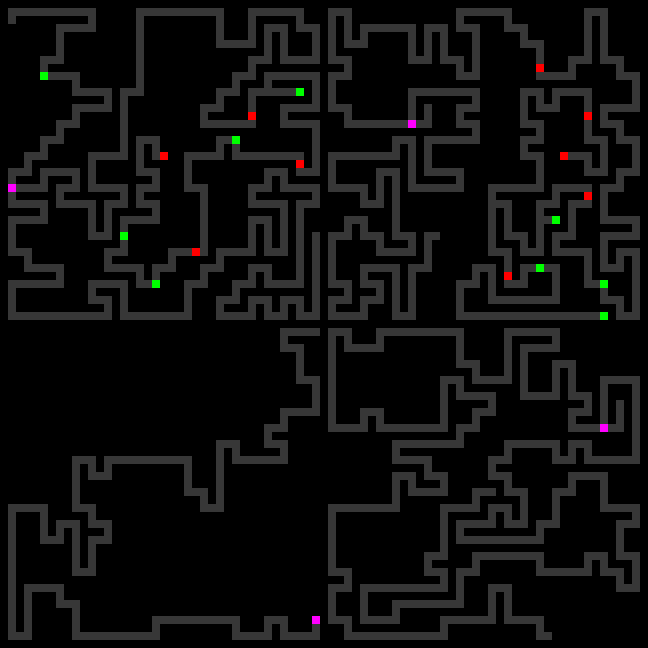

80463 17 26 1646
goal
part2: 1648 0


In [2]:
print("part2:",p1(open("18.txt").read()),1648)
      
      
#2130 too high
#learning: heurestic must never be too optimistic
